# 13장 세그멘테이션을 활용한 의심 결절 탐색

## 13.1 프로젝트에 두 번째 모델 추가하기

이번 분류기는 어디를 봐야 할지를 알려주는 단계다. 이를 위해 원본 CT 스캔을 받아 결절처럼 보이는 모든 부분을 찾아낼 것이다. 결절일 가능성이 있는 지점을 찾아 해당 복셀을 표시하는 작업을 세그멘테이션이라 한다. 단계별로 세분화해보면 이 장에서 다룰 계획은 다음과 같다
1. 세그멘테이션: 먼저 유넷 모델 세그멘테이션이 어떻게 동작하는지 확인한다. 새 모델의 각 요소를 알아보고 세그멘테이션 과정을 진행하면서 어떤 일이 일어나는지 알아본다.
2. 업데이트: 세그멘테이션을 구현하려면 크게 기존 코드 베이스의 세 부분을 바꿔야 하는데 다음과 같은 세부사항이 다르다\
a. 모델 업데이트: 기존 유넷을 우리 세그멘테이션 모델에 이식한다. 12장의 모델은 하나의 참/거짓 분류를 출력하지만 이 모델은 이미지 전체를 출력한다\
b. 데이터셋을 수정하여 CT 데이터 비트뿐 아니라 결절 마스크 정보도 제공한다. 분류 데이터셋은 결절 후보를 3차원으로 잘라낸 것으로 구성되지만 우리는 CT 단면 전체와 2차원 크롭이 필요하다.\
c. 훈련 루프도 새로운 종류의 손실값을 도입하고 최적화하도록 수정한다. 텐서보드에서 세그멘테이션 결과를 확인하고 모델 가중치를 디스크에 저장한다
3. 결과: 정량적인 세그멘테이션 결과를 통해 결실을 확인한다.

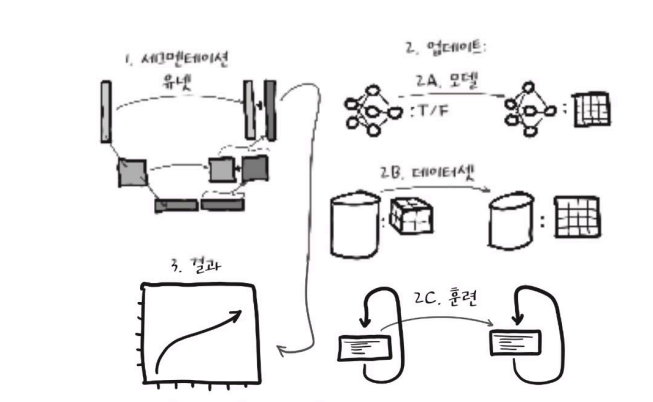

## 13.3 시멘틱 세그멘테이션: 픽셀 단위 분류

"사진에서 고양이가 어디에 있냐?"와 같은 질문을 답하기 위해 세그멘테이션을 사용한다. 아래 그림을 보자

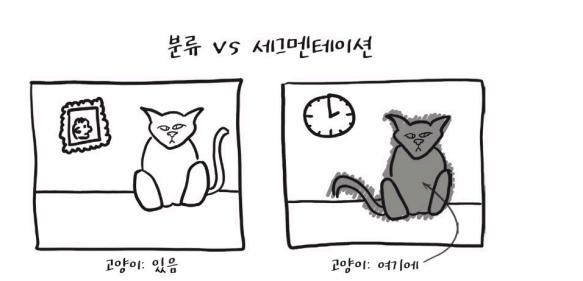

우리가 앞에서 만든 모델은 돋보기 같아서 다량의 픽셀을 가져와 결국 하나의 포인트로 집결하고, 이미지 안에 타겟이 존재하는지 여부만 알 수 있는 모델이다.
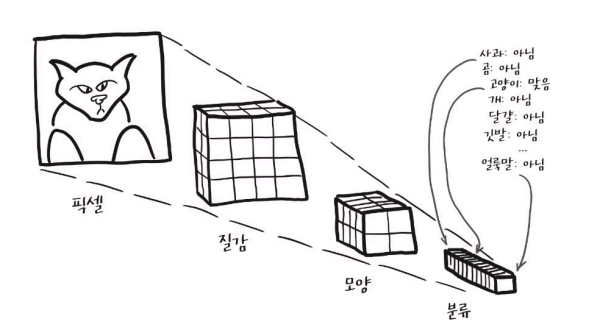

### 13.3.1 유넷 아키텍쳐

먼저 유넷이라 부르는 기본 세그멘테이션 알고리즘에 익숙해지자. 유넷 아키텍처는 세그멘테이션을 위해 고안되었으며 픽셀 단위로 출력을 만들어내는 신경망 설계다. U-Net이라는 이름처럼 알파벳 U와 비슷하다. 다음은 유넷 아키텍쳐다
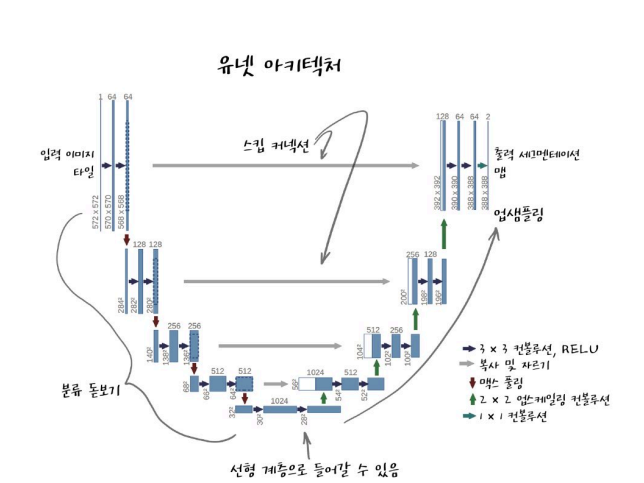

위 구조에서처럼 컨볼루션과 다운샘플링으로 향하다 다시 오른쪽 상단으로 올라가면서 업스케일링 컨볼루션을 통해 전체 해상도로 변한다. 

## 13.4 세그멘테이션을 위한 모델 업데이트

이제 코드를 업데이트하고 모델을 동작시키자. 참이나 거짓을 출력하는 이진분류 대신 세그멘테이션을 수행하여 모든 픽셀에 대한 확률을 출력하도록 만들자. 깃허브에서 유넷 세그멘테이션을 받아올 수 있다.

### 13.4.1 기성품 모델을 프로젝트에 적용하기

원래의 유넷을 수정해 우리의 필요에 맞춰보자. 순정 버전의 모델에서 하나씩 없애 보면서 결과에 미치는 영향을 보는 것은 좋은 경험이 된다.(제거연구라고 한다).
1. 입력을 배치 정규화에 통과시킨다. 이를 통해 직접 정규화할 필요가 없다.
2. 출력값에 제한이 없으므로 출력을 nn.Sigmoid 계층에 통과시켜 출력 범위를 [0, 1]로 제한한다. 
3. 모델의 전체 깊이와 필터 수를 사용할 만큼 줄일 것이다. 

In [ ]:
class UNetWrapper(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.input_batchnorm = nn.BatchNorm2d(kwargs['in_channels']) # 배치 정규화
        self.unet = UNet(**kwargs) # 한줄로 넣은 유넷이 모든 일을 진행
        self.final = nn.Sigmoid()

        self._init_weights() # 별도의 가중치 초기화를 만들어 사용
    
    

In [ ]:
def forward(self, input_batch):
        bn_output = self.input_batchnorm(input_batch)
        un_output = self.unet(bn_output)
        fn_output = self.final(un_output)
        return fn_output

## 13.5 세그멘테이션을 위한 데이터셋 업데이트

이전 데이터셋에서는 3차원 데이터를 만들었지만 이번에는 2차원 데이터를 만들어야 한다. 기존의 유넷은 페딩된 컨볼루션을 사용하지 않아 세그멘테이션 맵이 입력보다 작았고 출력의 모든 픽셀은 완전하게 밀집된 수용 필드를 가지고 있었다. 동일한 픽셀을 유지하는 접근 방식에는 두 가지 문제가 있다.

### 13.5.1 매우 제한된 입력 크기를 갖는 유넷

유넷 논문에서는 572x572 이미지 패치를 사용했고 출력 맵 크기는 388x388로 되어 있었다. 우리는 512x512로 입력은 큰데 출력은 작다. 결국 경계에 가까운 결절은 전혀 세그멘테이션 되지 않는다. 

### 13.5.2 2차원 vs 3차원 데이터 유넷 사용시 장단점

우리가 다루는 3차원 데이터가 유넷의 2차원 입력에 맞지 않는다. 지금의 512x512x128 이미지를 3차원으로 변환한 유넷 클래스에 넣어도 첫 계층만 2^6의 채널을 가지게 되며, 첫 컨볼루션만 8GB다. 결국 각 단면을 2차원 세그멘테이션 문제로 바라보고 인접한 단면을 별도 채널로 제공해서 3차원 정보에 대한 부분을 보완해야 한다. 

### 13.5.3 실축 데이터 만들기

#### 바운딩 박스
결절의 위치를 변환하여 결절 전체를 둘러싸는 바운딩 박스에 넣는 작업부터 하자. 결절 모양의 대략적인 중심 부위가 결절의 위치라 가정하면 각 차원에서 바깥쪽으로 저밀도 복셀을 만날 떄까지 뻗어나가서 일반 폐조직에 도달한 것을 나타낼 수 있다.결절의 중심점 위치를 에노테이션에서 얻어오고 이를 출발점으로 하여 복셀에서 탐색을 시작한다. 밑에 물음표가 표시된 열 축을 따라 인접한 복셀의 밀도를 검사한다. 고밀도 조직이면 탐색을 계속 진행한다. 경계값보다 낮은 복셀을 발견하면 중단한다.

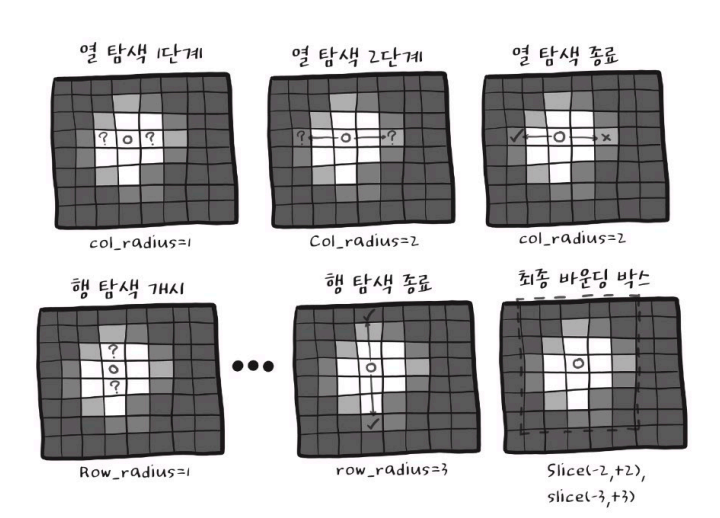

In [ ]:
for candidateInfo_tup in positiveInfo_list:
            center_irc = xyz2irc(
                candidateInfo_tup.center_xyz,
                self.origin_xyz,
                self.vxSize_xyz,
                self.direction_a,
            )
            ci = int(center_irc.index)
            cr = int(center_irc.row)
            cc = int(center_irc.col)# threshold_hu는 -700이다

            index_radius = 2
            try:# 인덱스를 벗어날 경우를 위한 try문
                while self.hu_a[ci + index_radius, cr, cc] > threshold_hu and \ #인덱스 radius
                        self.hu_a[ci - index_radius, cr, cc] > threshold_hu:
                    index_radius += 1
            except IndexError:
                index_radius -= 1
                row_radius = 2
            try:
                while self.hu_a[ci, cr + row_radius, cc] > threshold_hu and \ # row radius
                        self.hu_a[ci, cr - row_radius, cc] > threshold_hu:
                    row_radius += 1
            except IndexError:
                row_radius -= 1

            col_radius = 2
            try:
                while self.hu_a[ci, cr, cc + col_radius] > threshold_hu and \ # column radius
                        self.hu_a[ci, cr, cc - col_radius] > threshold_hu:
                    col_radius += 1
            except IndexError:
                col_radius -= 1

In [ ]:
boundingBox_a = np.zeros_like(self.hu_a, dtype=np.bool) #모두 False인 텐서로 시작
boundingBox_a[
                 ci - index_radius: ci + index_radius + 1,#모든 positiveInfo_list를 순회하며 결절 반경을 얻은 후 바운딩 박스를 표시
                 cr - row_radius: cr + row_radius + 1,
                 cc - col_radius: cc + col_radius + 1] = True

mask_a = boundingBox_a & (self.hu_a > threshold_hu) #마스크는 밀도 경계값보다 높은 복셀만 해당하도록 제한

#### CT 초기화 때 마스크 생성 호출하기

In [ ]:
self.positiveInfo_list = [
            candidate_tup
            for candidate_tup in candidateInfo_list
            if candidate_tup.isNodule_bool # 결절인 tuple만 저장
        ]
        self.positive_mask = self.buildAnnotationMask(self.positiveInfo_list) # buildAnnotationMask로 positive_mask 생성
        self.positive_indexes = (self.positive_mask.sum(axis=(1,2))# 각 단면마다 몇 개의 복셀 마스크가 참 값인지를 1차원 벡터에 담음
                                 .nonzero()[0].tolist()) # 0이 아닌 인덱스를 얻어 리스트로 만듬

#### CT와 함꼐 마스크도 캐싱하기

positive_mask에 대해 모든 CT 데이터를 읽어 파싱할 필요가 없도록 결절 후보 주위로 중심이 잡힌 여러 CT를 캐싱해준다.

In [ ]:
def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(center_xyz, self.origin_xyz, self.vxSize_xyz,
                             self.direction_a)

        slice_list = []
        #...
        ct_chunk = self.hu_a[tuple(slice_list)]
        pos_chunk = self.positive_mask[tuple(slice_list)]

        return ct_chunk, pos_chunk, center_irc

#### 에노테이션 데이터 정제하기

candidates.csv에 나열된 후보 데이터는 파일에 여러 번 나타나고 있다. 결절 데이터는 중복인데 에노테이션은 다른 경우처럼 완전하게 동일한 데이터가 아니다. 약간의 속임수를 써서 클린업된 annotation.csv 파일을 제공해보자. 

In [ ]:
with open('data/part2/luna/annotations_with_malignancy.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])
            isMal_bool = {'False': False, 'True': True}[row[5]]

            candidateInfo_list.append(
                CandidateInfoTuple(
                    True,# isNodule_bool
                    True, # hasAnnotation_bool
                    isMal_bool,
                    annotationDiameter_mm,
                    series_uid,
                    annotationCenter_xyz,
                )
            )

    with open('data/part2/luna/candidates.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            if not isNodule_bool:
                candidateInfo_list.append(
                    CandidateInfoTuple(
                        False, #isNodule_bool
                        False, #hasAnnotation_bool
                        False, #isMal_bool
                        0.0,
                        series_uid,
                        candidateCenter_xyz,
                    )
                )

### 13.5.4 Luna2dSegmentationDataset 구현

우리는 검증 데이터를 위해 일반적인 기본 클래스처럼 동작하는 클래스와, 랜덤화와 샘플 잘라내기를 수행해서 훈련셋을 위해 기본 클래스를 서브 클래싱하는 클라스를 만들어 본다. 각각의 CT 스캔 단면은 2차원 흑백 이미지라 생각하자.

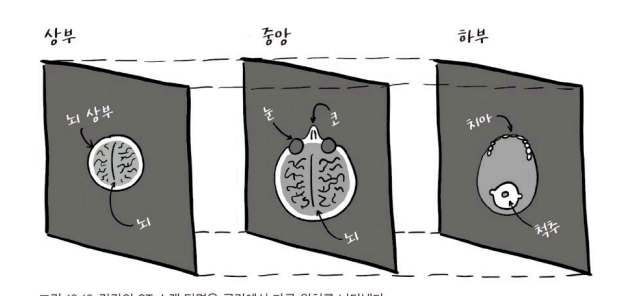

분류 모델에서는 단면을 3차원 데이터 배열로 취급하고 3차원 컨볼루션을 사용해 각 샘플을 처리했다. 세그멘테이션 모델에서는 각  단일 채널로 취급하고 여러 채널을 가진 2차원 이미지를 만든다. CT의 각 단면은 스택처럼 쌓여서 2차원 이미지처럼 처리된다.검증 과정에서는 검증용 CT 단면당 하나의 양성 마스크를 가진 샘플을 만든다. CT 스캔마다 단면 수가 다를 수 있으므로 각 CT 스캔의 크기와 양성 마스크를 디스크에 캐싱하는 함수를 만든다. 이 추출 과정은 모델 훈련 시작 전에 돌려야 하는 precache.py 스크립트 실행 중에 진행된다.

In [ ]:
@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, pos_chunk, center_irc = ct.getRawCandidate(center_xyz,
                                                         width_irc)
    ct_chunk.clip(-1000, 1000, ct_chunk)
    return ct_chunk, pos_chunk, center_irc

훈련인지 검증인지 구별하는 플래그를 다루는 부분도 수정한다. 개별 결절로 훈련하는 경우는 없으므로 연속된 리스트 전체를 받아 훈련셋과 검증셋으로 나눠야 한다.

In [ ]:
 if isValSet_bool:
            assert val_stride > 0, val_stride
            self.series_list = self.series_list[::val_stride]
            assert self.series_list
        elif val_stride > 0:
            del self.series_list[::val_stride]
            assert self.series_list

In [ ]:
 self.sample_list = []
        for series_uid in self.series_list:
            index_count, positive_indexes = getCtSampleSize(series_uid)

            if self.fullCt_bool:
                self.sample_list += [(series_uid, slice_ndx) #range를 사용해 sample_list를 전체 단면으로 확장
                                     for slice_ndx in range(index_count)]
            else:
                self.sample_list += [(series_uid, slice_ndx) # 관심 있는 단면만 사용
                                     for slice_ndx in positive_indexes]

        self.candidateInfo_list = getCandidateInfoList()  # 캐시됨

        series_set = set(self.series_list) # 빠른 참조를 위해 셋을 구성
        self.candidateInfo_list = [cit for cit in self.candidateInfo_list
                                   if cit.series_uid in series_set] # 셋에 없으면 걸러냄

        self.pos_list = [nt for nt in self.candidateInfo_list
                            if nt.isNodule_bool] # 나중의 데이터 밸런싱을 위해 실제 결절 리스트만 추출

## 13.6 세그멘테이션을 위한 훈련 스크립트 업데이트

새로운 모델을 훈련하기 위해 다음 세 가지를 업데이트 한다
- 새 모델 인스턴스가 필요하다
- 다이스 손실이라는 새 손실값을 소개한다
- 지금까지 사용한 취약한 SGD가 아닌 Adam을 사용한다.

### 13.6.1 세그멘테이션과 증간 모델 초기화
UnetWrapper 클래스를 사용하여 설정 파라미터를 전달하고, 두 번쨰로 증강용 모델을 만든다.

In [ ]:
def initModel(self):
        segmentation_model = UNetWrapper(
            in_channels=7,
            n_classes=1,
            depth=3,
            wf=4,
            padding=True,
            batch_norm=True,
            up_mode='upconv',
        )

        augmentation_model = SegmentationAugmentation(**self.augmentation_dict)
        #...
        return segmentation_model, augmentation_model

### 13.6.2 아담 옵티마이저 사용하기

아담은 각 파라미터별로 학습률을 관리할 수 있고 훈련을 진행하며 학습률을 자동으로 조정한다. 자동 조정 덕분에 스스로 적당한 학습률을 빠르게 찾아내므로 아담 사용시 별도의 학습률을 지정할 필요가 없다.

In [ ]:
def initOptimizer(self):
        return Adam(self.segmentation_model.parameters())

### 13.6.3 다이스 손실

aka 쇠렌센 다이스 계수인 다이스 손실은 세그멘테이션 작업에서 일반적으로 사용하는 손실 메트릭이다. 전체 이미지에서 작은 일부분이 양성인 경우도 처리하므로 장점이 있다. 쇠렌센 다이스 계수는 정확하게 세그멘트된 픽셀에 대해 예측 영역과 실제 픽셀을 합한 영역과의 비율에 대한 값이다. 밑의 그림에 다이스 점수 계산법이 있다.

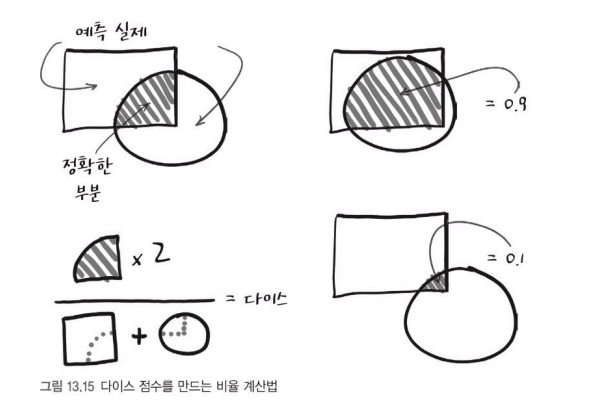

사실상 픽셀 단위의 F1점수를 사용하는 셈이다.

#### 손실값 가중치
이제 나머지 부류에 비해 한 부류가 더 선호되는 가중치 손실을 만들어 보려고 한다. fnLoss_g에 8을 곱하면 양성 픽셀 전체 개체는 음성 픽셀 전체 개체보다 8배 중요하게 설정되는 셈이다. 

### 13.6.5 메트릭 로깅 업데이트
각 에포크마다 잘 돌아가고 있는지 확인하기 위해 로깅을 해줘야 한다. 

In [ ]:
sum_a = metrics_a.sum(axis=1)
assert np.isfinite(metrics_a).all()

allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]
metrics_dict = {}
metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

metrics_dict['percent_all/tp'] = \
    sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100
metrics_dict['percent_all/fn'] = \
    sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
metrics_dict['percent_all/fp'] = \
    sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100

가능한 최고의 모델을 찾기 위해 재현율을 사용한다. 특정 에포크에서 F1점수가 나쁘지 않으면 재현율을 최대한 높인다. 

In [ ]:
score = metrics_dict['pr/recall']

return score

### 13.6.6 모델 저장

torch.save를 사용해 pickle을 사용해 모델 인스턴스를 직접 전닳여 저장하자. 모델 파라미터는 model.state_dict()을 사용해 얻을 수 있다.

In [ ]:
def saveModel(self, type_str, epoch_ndx, isBest=False):
    model = self.segmentation_model
    if isinstance(model, torch.nn.DataParallel):
            model = model.module

    state = {
            'sys_argv': sys.argv,
            'time': str(datetime.datetime.now()),
            'model_state': model.state_dict(),
            'model_name': type(model).__name__,
            'optimizer_state' : self.optimizer.state_dict(),
            'optimizer_name': type(self.optimizer).__name__,
            'epoch': epoch_ndx,
            'totalTrainingSamples_count': self.totalTrainingSamples_count,
        }
    torch.save(state, file_path)

## 13.7 결과

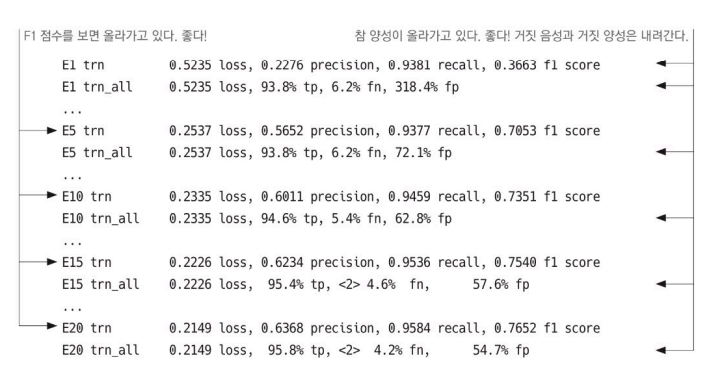

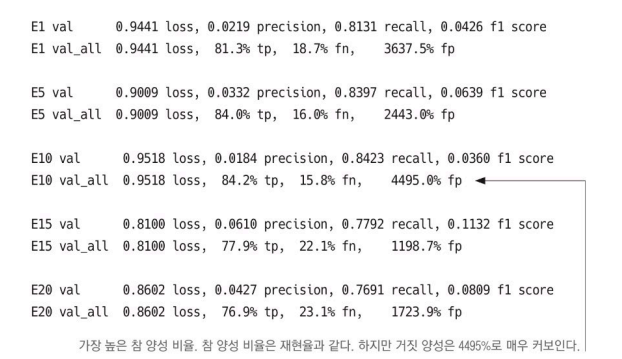

텐서보드에서 과적합이 일어난 것을 알 수 있다.

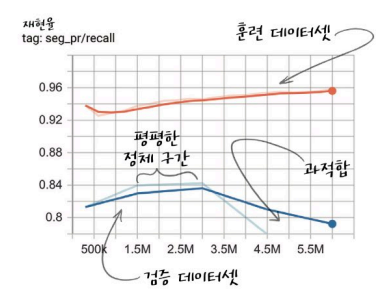